In [1]:
from bs4 import BeautifulSoup as bs
import re
from urllib.request import urlopen

In [2]:
#상장주식수와 유동비율을 구하는 함수
import re
def stock_info(stock_cd) :
    url_float = "http://companyinfo.stock.naver.com/company/c1010001.aspx?cmp_cd=" + stock_cd
    source = urlopen(url_float).read()
    source = bs(source,'lxml')
    tmp = source.find_all('tr')[9].find('td').text
    # 정보 다듬기
    tmp = tmp.replace('\t','')
    tmp = tmp.replace('\r','')
    tmp = tmp.replace('\n','')
    tmp = re.split('/',tmp)
    # 상장/발행 주식수
    outstanding = tmp[0].replace(',','')
    outstanding = int(outstanding.replace('주',''))
    outstanding

    #유통비율
    floating = float(tmp[1].replace("%",''))
    # floating = floating.replace(' ','')
    name = source.find('span',class_="name").text
    
    k10_outstanding[stock_cd] = outstanding
    k10_floating[stock_cd] = floating
    k10_name[stock_cd] = name
    print(name)
    print(str(outstanding) +' , ' + str(floating))

In [3]:
'''
005930 삼성전자
000660 sk하이닉스
068270 셀트리온
207940 삼성바이오로직스
005380 현대차
005490 포스코
051910 LG화학
028260 삼성물산
035420 NAVER
012330 현대모비스
'''
k10_component = ['005930', '000660', '068270' ,'207940' ,'005380' ,'005490', '051910' , '028260', '035420', '012330' ]
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()
for stock_cd in k10_component:
    stock_info(stock_cd)

삼성전자
5969782550 , 78.79
SK하이닉스
728002365 , 73.89
셀트리온
127953489 , 66.22
삼성바이오로직스
66165000 , 24.74
현대차
213668187 , 65.77
POSCO
87186835 , 79.52
LG화학
70592343 , 64.28
삼성물산
189690043 , 52.08
NAVER
164813395 , 78.15
현대모비스
97343863 , 67.12


In [4]:
URL = "https://finance.naver.com/item/sise_day.nhn?code=005930"
source = urlopen(URL).read()
source = bs(source,'lxml')
dates = source.find_all('span',class_="tah p10 gray03")
closing = source.find_all('td',class_="num") # 5의배수 = 종가
for n in range(len(dates)):
    print(dates[n].text,end=" : ")
    print(closing[6*n].text)

2019.04.12 : 46,850
2019.04.11 : 46,250
2019.04.10 : 46,700
2019.04.09 : 46,650
2019.04.08 : 46,650
2019.04.05 : 46,850
2019.04.04 : 46,950
2019.04.03 : 46,600
2019.04.02 : 45,750
2019.04.01 : 45,050


In [5]:
import datetime as dt
import pandas as pd
def date_format(d):
    d = str(d).replace('-','.')
    yyyy = int(d.split('.')[0])
    mm = int(d.split('.')[1])
    dd = int(d.split('.')[2])
    this_date = dt.date(yyyy,mm,dd)
    return this_date

In [6]:
def historical_naver_stock(stock_cd ,start_date='' ,end_date='' ,page_n=1,last_page =0):
    #print(stock_cd)
    if start_date :
        start_date = date_format(start_date)
    else :
        start_date = dt.date.today()
    if end_date :
        end_date = date_format(end_date)
    else : 
        end_date = dt.date.today()
    URL = "https://finance.naver.com/item/sise_day.nhn?code=" + stock_cd + '&page=' + str(page_n)
    source = urlopen(URL).read()
    source = bs(source,'lxml')
    dates = source.find_all('span',class_="tah p10 gray03") # 날짜 수집
    closing = source.find_all('td',class_="num") #종가 수집
    
    for n in range(len(dates)):
        
        if len(dates) > 0 :
            #날짜 처리
            this_date = dates[n].text
            #print(this_date)
            this_date = date_format(this_date)
            
            if this_date >= start_date and this_date <= end_date :
                this_close = closing[6*n].text
                this_close = this_close.replace(',','')
                this_close = float(this_close)
                
                his_prices[this_date] = this_close
                #print(this_close)
            elif this_date < start_date:
                # 함수종료
                return his_prices
        #페이지 네비게이션
    if last_page == 0 :
        last = source.find('td','pgRR').find('a')['href']
        # '/item/sise_day.nhn?code=005930&page=574' -> 574
        last = last.split('&')[1]
        #print(last)
        last_page = int(last.split('=')[1])
    if page_n < last_page :
        page_n = page_n + 1
        historical_naver_stock(stock_cd ,start_date ,end_date ,page_n ,last_page)
    return his_prices

In [7]:
k10_his_prices = dict()
for stock_cd in k10_component:
    his_prices = dict()
    start_date = '2019-2-1'
    end_date = '2019-04-12'
    historical_naver_stock(stock_cd,start_date,end_date)
    k10_his_prices[stock_cd] = his_prices


In [8]:
    
k10_his_prices = pd.DataFrame(k10_his_prices)
k10_his_prices = k10_his_prices.fillna(method="ffill")
#if k10_his_prices.isnull().values.any(): #그래도 구멍이 남아있으면
#    k10_his_prices = k10_his_prices.fillna(method="bfill")
#왜 에러가 나지
k10_his_prices

,005930,000660,068270,207940,005380,005490,051910,028260,035420,012330
2019-02-01,46350.0,75900.0,214500.0,388500.0,129500.0,270500.0,368000.0,117500.0,133500.0,224000.0
2019-02-07,46200.0,76700.0,214000.0,378500.0,126000.0,276000.0,369500.0,117500.0,129000.0,221000.0
2019-02-08,44800.0,73500.0,215000.0,378500.0,125500.0,264000.0,370000.0,115500.0,126000.0,218000.0
2019-02-11,45000.0,74100.0,215500.0,378500.0,127500.0,267000.0,372000.0,116500.0,125500.0,219500.0
2019-02-12,46050.0,75900.0,212500.0,377000.0,128500.0,265500.0,371500.0,117000.0,123500.0,222000.0
2019-02-13,46200.0,76200.0,212000.0,379500.0,124500.0,267000.0,378000.0,117500.0,125000.0,218500.0
2019-02-14,47500.0,77400.0,210000.0,382000.0,121500.0,266500.0,380000.0,117500.0,127500.0,218000.0
2019-02-15,46050.0,73800.0,209500.0,380000.0,121000.0,265500.0,380000.0,116000.0,127500.0,214000.0
2019-02-18,46200.0,74700.0,212000.0,379000.0,120500.0,262500.0,391000.0,116500.0,127000.0,210000.0
2019-02-19,45950.0,73700.0,215000.0,384500.0,119500.0,268500.0,390000.0,116000.0,126500.0,209000.0


In [9]:
tmp = {
    'Outstanding' : k10_outstanding,\
    'Floating' : k10_floating,\
    'Price' : k10_his_prices.iloc[0],\
    'name' : k10_name}
k10_info = pd.DataFrame(tmp)
k10_info

,Outstanding,Floating,Price,name
000660,728002365,73.89,75900.0,SK하이닉스
005380,213668187,65.77,129500.0,현대차
005490,87186835,79.52,270500.0,POSCO
005930,5969782550,78.79,46350.0,삼성전자
012330,97343863,67.12,224000.0,현대모비스
028260,189690043,52.08,117500.0,삼성물산
035420,164813395,78.15,133500.0,NAVER
051910,70592343,64.28,368000.0,LG화학
068270,127953489,66.22,214500.0,셀트리온
207940,66165000,24.74,388500.0,삼성바이오로직스


In [10]:
k10_info['f Market Cap'] = k10_info['Outstanding'] * k10_info['Price'] * k10_info['Floating'] * 0.01
k10_info['Market Cap'] = k10_info['Outstanding'] * k10_info['Price'] 

In [11]:
k10_info

,Outstanding,Floating,Price,name,f Market Cap,Market Cap
000660,728002365,73.89,75900.0,SK하이닉스,4.082820e+13,5.525538e+13
005380,213668187,65.77,129500.0,현대차,1.819858e+13,2.767003e+13
005490,87186835,79.52,270500.0,POSCO,1.875403e+13,2.358404e+13
005930,5969782550,78.79,46350.0,삼성전자,2.180115e+14,2.766994e+14
012330,97343863,67.12,224000.0,현대모비스,1.463553e+13,2.180503e+13
028260,189690043,52.08,117500.0,삼성물산,1.160789e+13,2.228858e+13
035420,164813395,78.15,133500.0,NAVER,1.719502e+13,2.200259e+13
051910,70592343,64.28,368000.0,LG화학,1.669865e+13,2.597798e+13
068270,127953489,66.22,214500.0,셀트리온,1.817476e+13,2.744602e+13
207940,66165000,24.74,388500.0,삼성바이오로직스,6.359442e+12,2.570510e+13


In [12]:
k10_his_mc = k10_his_prices * k10_info['Outstanding'] * k10_info['Floating'] * 0.01
k10_his_mc

,000660,005380,005490,005930,012330,028260,035420,051910,068270,207940
2019-02-01,4.082820e+13,1.819858e+13,1.875403e+13,2.180115e+14,1.463553e+13,1.160789e+13,1.719502e+13,1.669865e+13,1.817476e+13,6.359442e+12
2019-02-07,4.125854e+13,1.770673e+13,1.913535e+13,2.173059e+14,1.443952e+13,1.160789e+13,1.661542e+13,1.676671e+13,1.813239e+13,6.195750e+12
2019-02-08,3.953719e+13,1.763646e+13,1.830338e+13,2.107209e+14,1.424351e+13,1.141031e+13,1.622901e+13,1.678940e+13,1.821712e+13,6.195750e+12
2019-02-11,3.985994e+13,1.791752e+13,1.851137e+13,2.116616e+14,1.434152e+13,1.150910e+13,1.616461e+13,1.688015e+13,1.825949e+13,6.195750e+12
2019-02-12,4.082820e+13,1.805805e+13,1.840737e+13,2.166004e+14,1.450486e+13,1.155850e+13,1.590701e+13,1.685747e+13,1.800530e+13,6.171196e+12
2019-02-13,4.098958e+13,1.749593e+13,1.851137e+13,2.173059e+14,1.427618e+13,1.160789e+13,1.610021e+13,1.715241e+13,1.796293e+13,6.212119e+12
2019-02-14,4.163508e+13,1.707434e+13,1.847670e+13,2.234206e+14,1.424351e+13,1.160789e+13,1.642221e+13,1.724317e+13,1.779347e+13,6.253042e+12
2019-02-15,3.969857e+13,1.700408e+13,1.840737e+13,2.166004e+14,1.398216e+13,1.145971e+13,1.642221e+13,1.724317e+13,1.775110e+13,6.220304e+12
2019-02-18,4.018269e+13,1.693381e+13,1.819938e+13,2.173059e+14,1.372081e+13,1.150910e+13,1.635781e+13,1.774231e+13,1.796293e+13,6.203935e+12
2019-02-19,3.964477e+13,1.679328e+13,1.861537e+13,2.161300e+14,1.365547e+13,1.145971e+13,1.629341e+13,1.769694e+13,1.821712e+13,6.293965e+12


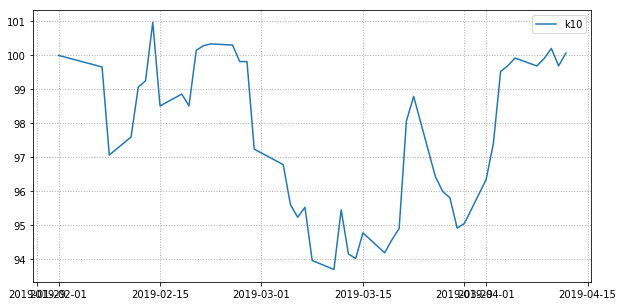

In [13]:
k10_his_mc.sum(axis=1) # 일자별 시가총액 합
# ...sum() 각 열의 합 세로방향
k10 = pd.DataFrame()
k10['k10 Market Cap'] = k10_his_mc.sum(axis=1)
k10['k10'] = k10['k10 Market Cap'] / k10['k10 Market Cap'][0] *100 #k10 지수 산출

# K10 지수 그림그리기
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,5))
plt.plot(k10['k10'])
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle=":", linewidth=1)

In [14]:

def his_naver_index(his_prices, index_cd, start_date='', end_date='', page_n=1, last_page=0):
    #date 정리
    if start_date :
        start_date = date_format(start_date)
    else :
        start_date = dt.date.today()
    if end_date :
        end_date = date_format(end_date)
    else :
        end_date = dt.date.today()
    # bs 하기 및 저장
    naver_index = 'http://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + '&page=' + str(page_n)
    source = urlopen(naver_index).read()
    source = bs(source,'lxml') # .prettify
    dates = source.find_all('td',class_="date")
    prices = source.find_all('td',class_="number_1")
    # 사이값만 저장하기
    for n in range(len(dates)):
        # 날짜 처리 및 확인
        this_date = dates[n].text
        if this_date.split('.')[0].isdigit() :
            this_date = date_format(this_date)
            if start_date <= this_date and end_date >= this_date:
                this_price = float(prices[4*n].text.replace(',','')) # '23,429.30' -> 23429.30 (float)
                his_prices[this_date] = this_price # 딕셔너리에 저장
            elif start_date > this_date :
                return his_prices
        #마지막페이지 주소 추출
    if last_page == 0 :
        last_page = source.find('td',class_='pgRR').find('a')['href']
        # '/sise/sise_index_day.nhn?code=KPI200&page=547' - > 547
        last_page = last_page.split('&')[1].split('=')[1]
        last_page = int(last_page)
    # 다음 페이지 호출
    if last_page > page_n :
        page_n = page_n + 1
        his_naver_index(his_prices,index_cd, start_date, end_date, page_n, last_page)
    return his_prices


In [15]:
index_cd = 'KPI200'
KPI_prices = dict()
kospi200 = his_naver_index(KPI_prices,index_cd,"2019-2-1","2019-4-12")


Text(0.5, 1.0, 'k10 지수 vs k200 지수')

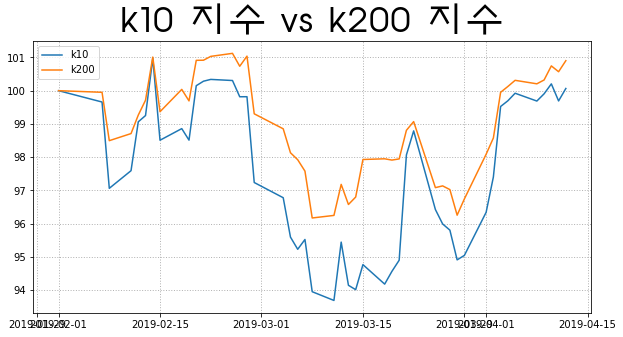

In [23]:
k200 = pd.DataFrame({'k200' : kospi200})
%matplotlib inline
plt.figure(figsize=(10,5))
plt.plot(k10['k10']/ k10['k10'][0] * 100)
plt.plot(k200['k200'] / k200['k200'][0] * 100)
plt.legend(loc=0)
plt.grid(True, color='0.7', linestyle =":", linewidth=1)

#한글 폰트 설정
plt.rcParams['font.family'] = 'HYnamM'
plt.rcParams['axes.unicode_minus'] = False
font_title = {'family' : 'HYnamM', 'color' : 'black', 'weight' : 'bold', 'size' : 40}
plt.title('k10 지수 vs k200 지수',fontdict=font_title)

In [22]:
from matplotlib import font_manager
set(sorted([f.name for f in font_manager.fontManager.ttflist]))

{'? ??',
 '???',
 '????',
 '??????',
 'Agency FB',
 'Algerian',
 'AmeriGarmnd BT',
 'Ami R',
 'Arial',
 'Arial Rounded MT Bold',
 'Baskerville BT',
 'Baskerville Old Face',
 'Bauhaus 93',
 'Bell MT',
 'Berlin Sans FB',
 'Berlin Sans FB Demi',
 'Bernard MT Condensed',
 'BernhardFashion BT',
 'Blackadder ITC',
 'Blippo Blk BT',
 'Bodoni Bd BT',
 'Bodoni Bk BT',
 'Bodoni MT',
 'Book Antiqua',
 'Bookman Old Style',
 'Bookshelf Symbol 7',
 'Bradley Hand ITC',
 'Britannic Bold',
 'Broadway',
 'BroadwayEngraved BT',
 'Brush Script MT',
 'BrushScript BT',
 'Calibri',
 'Californian FB',
 'Calisto MT',
 'Cambria',
 'Candara',
 'Castellar',
 'CentSchbook BT',
 'Centaur',
 'Century',
 'Century Gothic',
 'Century Schoolbook',
 'Chiller',
 'Colonna MT',
 'Comic Sans MS',
 'CommercialScript BT',
 'Consolas',
 'Constantia',
 'Cooper Black',
 'Cooper Blk BT',
 'Copperplate Gothic Bold',
 'Copperplate Gothic Light',
 'Corbel',
 'Courier New',
 'Courier10 BT',
 'Curlz MT',
 'DejaVu Sans',
 'DejaVu Sans D